In [1]:
from geopandas.tools import sjoin_nearest
from scipy.spatial import cKDTree
from IPython.display import Image
import geopandas as gpd
from pyproj import CRS
import pandas as pd

import warnings
warnings.filterwarnings("ignore")


from raster_functions import *
EPSG_Namibia_Code = 32733

/tmp/ipykernel_162733/1060763125.py:1: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  from geopandas.tools import sjoin_nearest


In [2]:
%%time

directory = '/DATA/magalhaes/icesat2_atl03/atl03_hdf_window/'

file_pattern = ['ATL03_TOC', 'ATL03_Grass']
start_date = '2018-10-01'
nmonths = 41 

dfs_list = merge_df_nmonths(directory, start_date, nmonths, file_pattern)

CPU times: user 25.6 s, sys: 5.13 s, total: 30.8 s
Wall time: 1min 16s


In [3]:
gdf_TOC, gdf_Grass = convert_to_geodataframe(dfs_list)

In [4]:
area_paths = ['../raster_analysis/oshana_delta_areas/oshana_delta.geojson']

clipped_gdfs = []
for path in area_paths:
    clip_gdf = gpd.read_file(path)
    gdf_TOC.loc[gdf_TOC.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_TOC[gdf_TOC['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_TOC.drop('clipped', axis=1, inplace=True)

# Access the clipped GeoDataFrames as clipped_gdfs[0], clipped_gdfs[1], etc.
oshana_TOC = clipped_gdfs[0]

del gdf_TOC, dfs_list

In [5]:
area_paths = ['../raster_analysis/oshana_delta_areas/oshana_delta.geojson'] 

clipped_gdfs = []
for path in area_paths:
    with open(path) as f:
        clip_gdf = gpd.read_file(f)
    gdf_Grass.loc[gdf_Grass.intersects(clip_gdf.unary_union), 'clipped'] = True
    clipped_gdf = gdf_Grass[gdf_Grass['clipped'] == True].copy()
    clipped_gdfs.append(clipped_gdf)
    gdf_Grass.drop('clipped', axis=1, inplace=True)

# Access the clipped GeoDataFrames as clipped_gdfs[0], clipped_gdfs[1], etc.
oshana_Grass = clipped_gdfs[0]

del gdf_Grass

In [6]:
oshana_Grass.shape, oshana_TOC.shape

((1579752, 18), (1522412, 19))

In [7]:
# Reset index to use Dates
oshana_TOC = oshana_TOC.set_index('Date')
oshana_Grass = oshana_Grass.set_index('Date')

# Calculate median values for each month
oshana_TOC_median = oshana_TOC.groupby(oshana_TOC.index.strftime('%Y-%m'))['TOC_Height'].median().reset_index()
oshana_Grass_median = oshana_Grass.groupby(oshana_Grass.index.strftime('%Y-%m'))['Grass_Height'].median().reset_index()
oshana_Grass_median = oshana_Grass_median.set_index('Date')
oshana_TOC_median = oshana_TOC_median.set_index('Date')

In [8]:
oshana_TOC.head()

,Latitude,Longitude,Along-track_Distance,Land,Easting,Northing,crosstrack,alongtrack,Ground_interp_Height,TOC_Height,z,x,NN,Photons_Numb,easting_sq,northing_sq,geometry,clipped
Date,,,,,,,,,,,,,,,,,,
2018-10-14,-18.693566,15.681549,16.786613,2.0,571864.573814,7.932941e+06,2604.816485,1.808212e+06,1123.066932,3.882653,0.052380,0.565546,9.0,2.0,571,7932,POINT (571864.574 7932941.225),True
2018-10-14,-18.699407,15.680937,5.794528,4.0,571797.645819,7.932295e+06,2605.231494,1.808862e+06,1126.775796,3.508506,0.030176,0.567496,12.0,1.0,571,7932,POINT (571797.646 7932295.203),True
2018-10-14,-18.699765,15.680900,5.624427,4.0,571793.586150,7.932256e+06,2605.209027,1.808902e+06,1126.976030,3.365400,0.021683,0.567616,10.0,1.0,571,7932,POINT (571793.586 7932255.552),True
2018-10-14,-18.701842,15.680684,16.423773,4.0,571769.877081,7.932026e+06,2605.265954,1.809133e+06,1127.207553,3.399625,0.023714,0.568310,11.0,1.0,571,7932,POINT (571769.877 7932025.821),True
2018-10-14,-18.701932,15.680674,6.366447,4.0,571768.836658,7.932016e+06,2605.286424,1.809143e+06,1127.208094,3.106848,0.006339,0.568340,16.0,1.0,571,7932,POINT (571768.837 7932015.915),True


#### Boxplot of ATL03 for oshana delta region

In [9]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import seaborn as sns
import ee

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

# ee.Authenticate()

In [10]:
ee.Initialize()

In [11]:
from shapely.geometry import Polygon

# define region of interest
minx, maxx = 15.5, 17
miny, maxy = -19.4, -18.2
aoi = Polygon([[minx, maxy], [maxx, maxy], [maxx, miny], [minx, miny]])
ROI = gee_geometry_from_shapely(aoi)
# define period of time series analysis
start_date = '2018-10-01'
end_date = '2022-03-30'

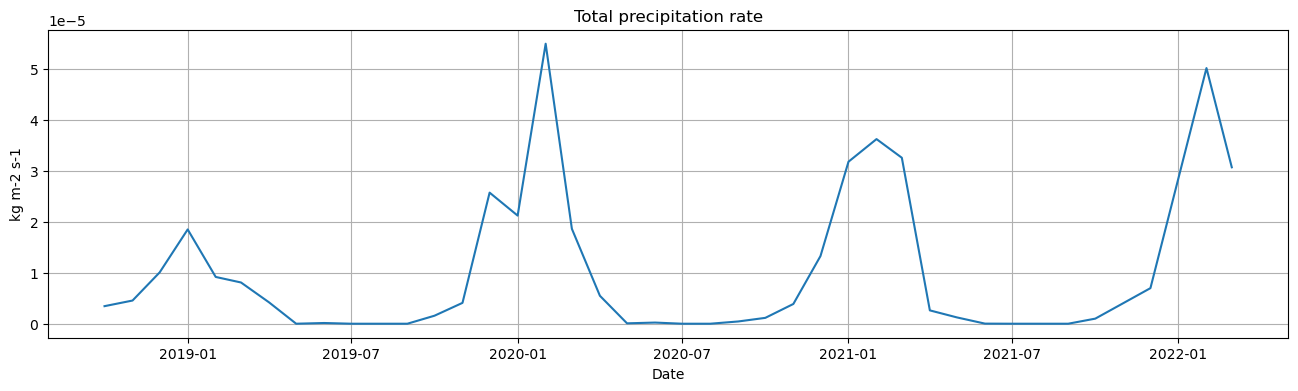

In [12]:
def createTS(image):
    date = image.get('system:time_start')
    value = image.reduceRegion(reducer=ee.Reducer.mean(), geometry=ROI).get(var)
    std = image.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=ROI).get(var)
    ft = ee.Feature(None, {'date': ee.Date(date).format('Y/M/d'), var: value, 'STD': std})
    return ft

def TS_to_pandas(TS):
    dump = TS.getInfo()
    fts = dump['features']
    out_vals = np.empty((len(fts)))
    out_dates = []
    out_std = np.empty((len(fts)))
    
    for i, f in enumerate(fts):
        props = f['properties']
        date = props['date']
        val = props[var]
        std = props['STD']
        out_vals[i] = val
        out_std[i] = std
        out_dates.append(pd.Timestamp(date))
    
    ser = pd.Series(out_vals, index=out_dates)
    return ser, out_std

# Source of precipitation and soil moisture data
# https://developers.google.com/earth-engine/datasets/catalog/NASA_FLDAS_NOAH01_C_GL_M_V001#description

Precip = ee.ImageCollection('NASA/FLDAS/NOAH01/C/GL/M/V001').filter(ee.Filter.date(start_date, end_date)).select('Rainf_f_tavg').filterBounds(ROI)     
var = 'Rainf_f_tavg'
TS = Precip.map(createTS)
Precip_ts, Precip_std = TS_to_pandas(TS)
precipitation = Precip_ts.groupby(Precip_ts.index.date).median()

precipitation.plot(figsize=(16,4))
plt.title('Total precipitation rate')
plt.xlabel('Date')
plt.ylabel('kg m-2 s-1')
plt.grid()

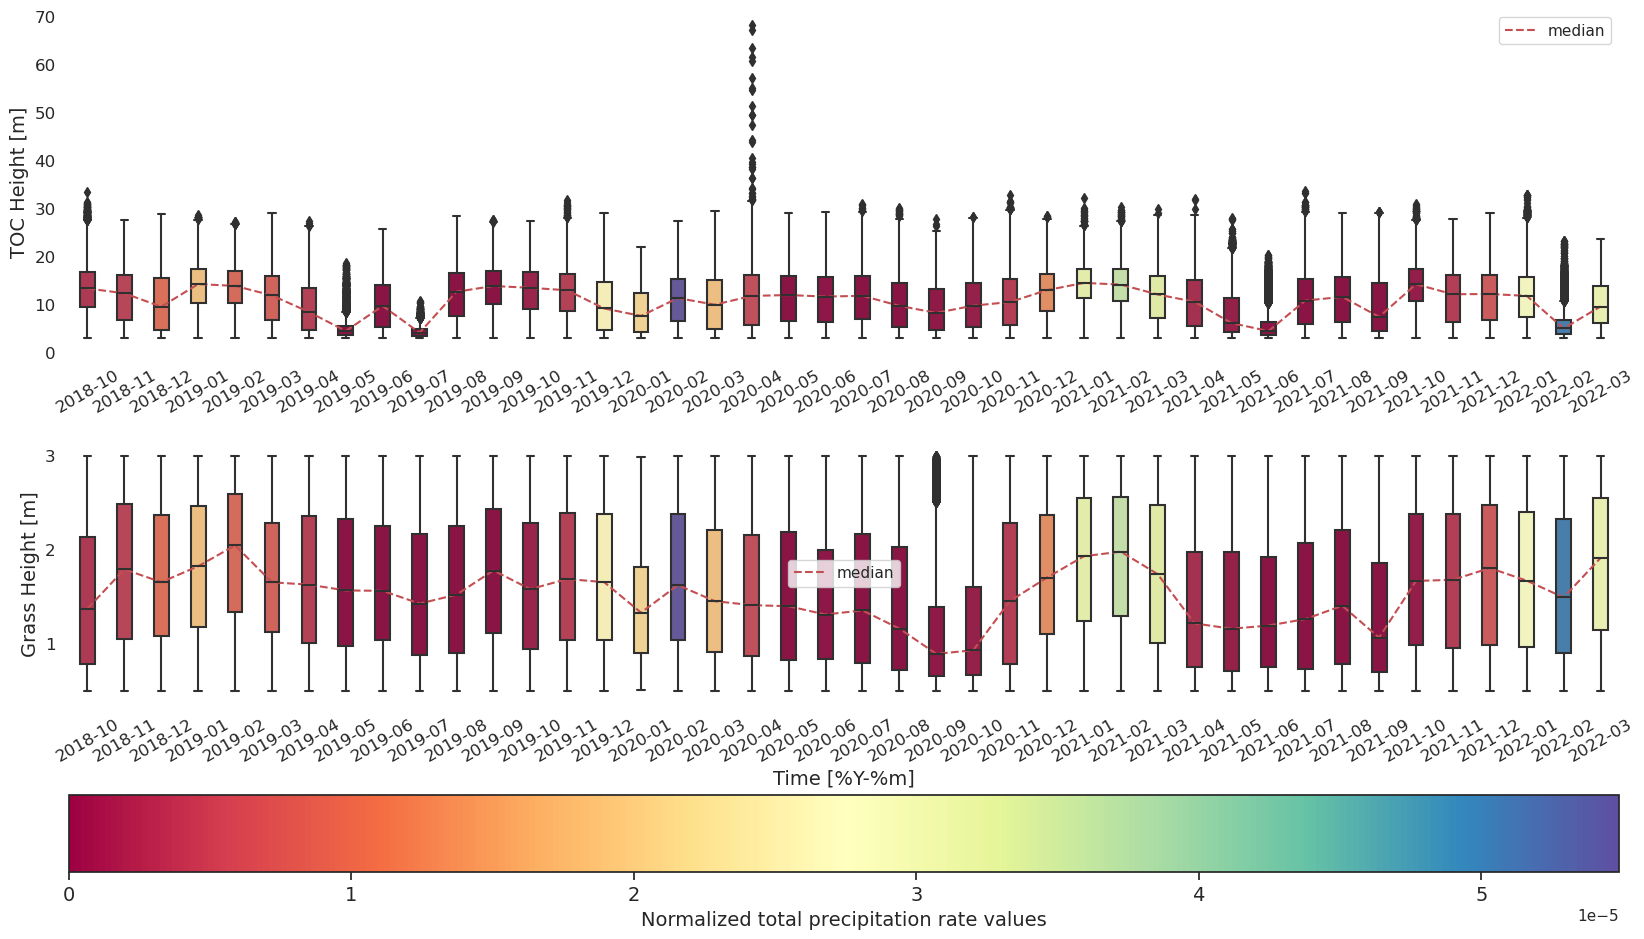

In [14]:
palette = 'Spectral'
sns.set(style='white')

fig, axs = plt.subplots(2,1, figsize=(20, 12), gridspec_kw={'height_ratios': [8, 6]})
plt.subplots_adjust(hspace=0.3)

for ax in axs:
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)

norm = plt.Normalize(precipitation.min(), precipitation.max())
colors = plt.cm.Spectral(norm(precipitation))

sns.lineplot(data=oshana_TOC_median, x='Date', y='TOC_Height', ax=axs[0], linestyle='--',color='r', label='median')
sns.boxplot(x = oshana_TOC.index.strftime('%Y-%m'),
            y = oshana_TOC['TOC_Height'],
            palette = colors,
            ax=axs[0], width=0.4)

axs[0].set_xlabel('', fontsize=14)
axs[0].set_ylabel('TOC Height [m]', fontsize=14)
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=30)

sns.lineplot(data=oshana_Grass_median, x='Date', y='Grass_Height', ax=axs[1], linestyle='--',color='r', label='median')
sns.boxplot(x = oshana_Grass.index.strftime('%Y-%m'),
            y = oshana_Grass['Grass_Height'],
            palette = colors,
            ax=axs[1], width=0.4)

axs[1].set_ylabel('Grass Height [m]', fontsize=14)
axs[1].set_xlabel('Time [%Y-%m]', fontsize=14)
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=30)
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

sm = plt.cm.ScalarMappable(cmap=palette, norm=plt.Normalize(vmin=precipitation.min(), vmax=precipitation.max()))
sm.set_array([])

cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), orientation='horizontal', pad=0.1)
cbar.ax.set_xlabel('Normalized total precipitation rate values', fontsize=14)
cbar.ax.tick_params(axis='both', which='major', labelsize=14)

In [ ]:
import pandas as pd
from tabulate import tabulate
import geopandas as gpd

# Calculate the descriptive statistics for TOC_Height and Grass_Height
grass = oshana_Grass[['Grass_Height']].describe().round(2)
toc = oshana_TOC[['TOC_Height']].describe().round(2)


In [ ]:
# Combine the two DataFrames into a single DataFrame
statistics = pd.concat([grass, toc], axis=1)

# Set the column names to 'Grass_Height' and 'TOC_Height'
statistics.columns = ['Grass_Height', 'TOC_Height']

# Convert the statistics to a list of lists for tabulate
table_data = statistics.reset_index().values.tolist()

# Add a header row to the table
header_row = [''] + statistics.columns.tolist()
table_data.insert(0, header_row)

# Format the table as LaTeX and print it
latex_table = tabulate(table_data, headers='firstrow', tablefmt='latex_booktabs', floatfmt='.2f')
print(latex_table)

---